In [68]:
import numpy as np 
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib

import datetime
from os.path import exists
import glob
import tqdm


from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.table import Table, vstack, hstack
import astropy.units as u
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarWebQuery


from ResidualUtils import getwavs, getspecpath, getapstarpath





matplotlib.rcParams.update({'xtick.labelsize':15,
                            'ytick.labelsize':15,
                            'axes.titlesize':15,
                            'axes.labelsize':15,
                            'font.size':15,
                            'xtick.top':True,
                            'xtick.minor.visible':True,
                            'ytick.minor.visible':True,
                            'xtick.major.size':4,
                            'xtick.minor.size':2,
                            'ytick.major.size':4,
                            'ytick.minor.size':2,
                            'ytick.right':True,
                            'xtick.direction':'in',
                            'ytick.direction':'in',
                            'font.family':'serif',
                            'text.usetex': False,
                            'pgf.texsystem': 'pdflatex'})



from TolColors import tol_cmap
rainbow = tol_cmap('rainbow_PuRd')
sunset = tol_cmap('sunset')
iridescent = tol_cmap('iridescent')
for map in [rainbow, sunset, iridescent]:
    map.set_bad('white',1.)

Configuration file not found:

    /Users/aidanmcbride/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


In [53]:
# Read in some useful tables:
# tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits'
tabfile = 'allStarLite-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1) # allStarLite base file


# select all CA Cloud stars from the allStarLite file
CA_fields = ['CA_161-06_btx', 'CA_161-06_btx', 'CA_162-11_btx', 'CA_163-05_btx', 'CA_163-08_btx',
             'CA_165-07_btx', 'CA_165-10_btx']
CA_inds = np.unique(np.concatenate([np.where(stars['FIELD'] == field)[0] for field in CA_fields]))
CA_stars = stars[CA_inds]
CA_clean = CA_stars[np.invert(np.logical_or.reduce([np.isnan(CA_stars['TEFF']), np.isnan(CA_stars['LOGG']), 
                                           np.isnan(CA_stars['M_H'])]))]
# for our purposes, requires that all CA cloud stars have TEFF, LOGG, and M_H

select_bitmasked = np.where((np.bitwise_and(stars['ASPCAPFLAG'], 23) == 0) | 
                            (np.bitwise_and(stars['ASPCAPFLAG'], 19) == 0))[0] # perhaps I should also bitmask CA_clean

stars = stars[select_bitmasked]
stars = stars[np.where((stars['TEFF_ERR'] < 600) & (stars['LOGG_ERR'] < 0.5) & (stars['M_H_ERR'] < 0.3))[0]]
stars = stars[np.where(np.abs(stars['GLAT']) > 10)[0]] # clean up the allStarLite data file

In [54]:
### OLD VERSION ###

meta = Table(fits.open('ResidualsFiles/meta_table.fits')[1].data)

def get_residual(teff, logg, m_h):
    rowselect = np.where(np.logical_and.reduce(
                    [teff >= meta['teff_low'], teff < meta['teff_high'], 
                    logg >= meta['logg_low'], logg < meta['logg_high'],
                   m_h >= meta['m_h_low'], m_h < meta['m_h_high']]))[0]
    if len(rowselect) != 1:
        return 
    
    
    row = meta[rowselect]
    j, k = (row['j_ind'], row['k_ind'])
    filename = row['fname'].item()
    hdulist = fits.open(filename)
    hdulist = np.array(hdulist)[1:].reshape(30,12)
    hdu = hdulist[j, k].item()
    return hdu # may want to make it return the path


### USE THIS ONE NOW ####

meta_new = Table(fits.open('Residuals/meta.fits')[1].data)

# if I change the data structure, I'll make an equivalent get_residual function
def get_medres(teff, logg, m_h, dir = 'Residuals/'):
    rowselect = np.where(np.logical_and.reduce(
                    [teff >= meta_new['TEFF_MIN'], teff < meta_new['TEFF_MAX'], 
                    logg >= meta_new['LOGG_MIN'], logg < meta_new['LOGG_MAX'],
                   m_h >= meta_new['M_H_MIN'], m_h < meta_new['M_H_MAX']]))[0]
    if len(rowselect) != 1:
        return 
    
    row = meta_new[rowselect]
    filename = row['FNAME'].item()
    return dir + filename

In [55]:
# get aspcapStar file path from an allstar table row
def get_aspcapStar(row):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    telescope = np.array(row['TELESCOPE'], dtype = str)
    field = np.array(row['FIELD'], dtype = str)
    sourceid = np.array(row['APOGEE_ID'], dtype = str)
#     length = len(sourceid)
    path = (specdir + specname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid)
    path = '/Users/aidanmcbride/Documents/ISM/Files/aspcap/' + specname.format(SOURCEID = sourceid) # LOCAL MACHINE ONLY
    return path

# get apStar/asStar file path from an aspcapStar hdulist
def get_apStar(hdulist):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/redux/dr17/stars/{TELESCOPE}/{FIELD}/'
    telescope = str(hdulist[4].data['TELESCOPE'][0])
    field = str(hdulist[4].data['FIELD'][0])
    fname = str(hdulist[4].data['FILE'][0])
    path = ((specdir + fname).format(TELESCOPE = telescope, FIELD = field))
    path = '/Users/aidanmcbride/Documents/ISM/Files/apstar/' + fname # LOCAL MACHINE ONLY
    return path

# get wavelength array for some aspcapStar/apStar hdulist; if no hdulist given, uses default values
# can be rv-corrected from the stellar rest frame to the observed frame
def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs 

# creates a mask from pixel-wise apStar/asStar bitmask
def create_mask(bitmask, flags = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], skipflags = []): 
    # https://www.sdss.org/dr14/algorithms/bitmasks/ APOGEE_PIXMASK
    if type(flags) is not list:
        flags = [flags]
    if type(skipflags) is not list:
        skipflags = [skipflags]

    mask = np.zeros(bitmask.shape)
    for i in flags:
        if i not in skipflags:
            mask[np.bitwise_and(bitmask, 2**i) == 2**i] = 1
    return mask

In [244]:
wavs = get_wavs()

def resample_interp(data, rv, resample_wavelengths = wavs):
    wavs_rv = get_wavs(rv = rv)
    interp = interp1d(wavs_rv, data, kind = 'slinear', bounds_error = False)
    
    data_interp = interp(resample_wavelengths)
    
    return data_interp

/var/folders/pz/sgyllgv13qnfqwl9zwk1zd380000gn/T/ipykernel_37698/4016456550.py:11: RuntimeWarning: invalid value encountered in true_divide
  res = aspcap[1].data/aspcap[3].data


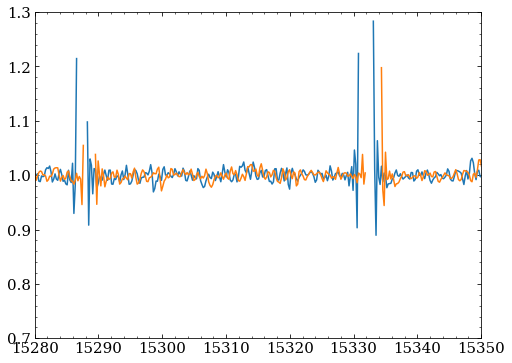

In [247]:
star = CA_clean[0]
aspcap = fits.open(get_aspcapStar(star))
apstar = fits.open(get_apStar(aspcap))
medres = fits.open(get_medres(star['TEFF'], star['LOGG'], star['M_H']))

mask = create_mask(apstar[3].data[0], skipflags = [10,11])

fig, ax = plt.subplots(figsize = (8,6))


res = aspcap[1].data/aspcap[3].data 
res_c = res / medres[1].data

res = ma.array(res, mask = mask)
res_c = ma.array(res_c, mask = mask)
ax.plot(wavs, res_c)

res_c_resamp = resample_interp(res_c, star['VHELIO_AVG'])


res_c_resamp = resample_interp(res_c.filled(np.nan), star['VHELIO_AVG'])

ax.plot(wavs, res_c_resamp)

ax.set_xlim(15280, 15350)
ax.set_ylim(.7, 1.3)

plt.show()

In [248]:
run = True
if run: 

    wavs = get_wavs()


    table_add_cols = ['MEDRES_NBIN', 'FILE']
    table_add = np.zeros((len(CA_clean), 2), dtype = 'object')


    for i in tqdm.tqdm(range(len(CA_clean)), total = len(CA_clean)):
        specflag = False
        medresflag = False 

        row = CA_clean[i]
        apogee_id = row['APOGEE_ID']
        telescope = row['TELESCOPE']
        field = row['FIELD']
        rv = row['VHELIO_AVG']


        aspcap_fname = get_aspcapStar(row)
        if not exists(aspcap_fname):
            table_add[i, :] = [np.nan, ''] 
            continue

        aspcap_f = get_aspcapStar(row)
        aspcap = fits.open(aspcap_f)

        apstar_f = get_apStar(aspcap)
        apstar = fits.open(apstar_f)

        medres_f = get_medres(row['TEFF'], row['LOGG'], row['M_H'])
        medres = fits.open(medres_f)


        bitmask = apstar[3].data[0]
        mask = create_mask(bitmask, skipflags = [10, 11])


        spectrum = aspcap[1].data
        model = aspcap[3].data
        residual_uncorrected = spectrum / model

        residual_uncorrected_masked = ma.array(residual_uncorrected, mask = mask)

        median_residual = medres[1].data
        if median_residual is None:
            median_residual = np.zeros(len(wavs))
            median_residual[:] = np.nan

        n_pix = medres[7].data # not used
        residual = residual_uncorrected / median_residual

        residual_masked = ma.array(residual, mask = mask)


        residual_interp = resample_interp(residual_masked.filled(np.nan), rv)
        residual_uncorrected_interp = resample_interp(residual_uncorrected_masked.filled(np.nan), rv)


#         data = [residual_masked.filled(np.nan), residual_uncorrected_masked.filled(np.nan), wavs]
        data = [residual_interp, residual_uncorrected_interp, wavs]
        data_names = ['RES', 'RES_RAW', 'WAVS']

        hdu0 = fits.PrimaryHDU()
        hdu0.header['ID'] = apogee_id
        hdu0.header['TSCOPE'] = telescope
        hdu0.header['FIELD'] = field

        hdulist = fits.HDUList([hdu0])
        for j in range(len(data)):
            hduj = fits.ImageHDU(data[j])
            hdu0.header['ID'] = apogee_id
            hdu0.header['TSCOPE'] = telescope
            hdu0.header['FIELD'] = field
            hduj.header['NAME'] = data_names[j]


            hdulist.append(hduj)

        nbin = medres[0].header['NBIN']
        CA_residual_fname = 'res_{id}.fits'.format(id = apogee_id)
        table_row = [nbin, CA_residual_fname]
        table_add[i, :] = table_row

        hdulist.writeto('CACloudResiduals/' + CA_residual_fname.format(id = apogee_id), overwrite = True)



    addtab = Table(names = table_add_cols, data = table_add)
    datatype = [int, str]
    for i in range(len(table_add_cols)):
        col = table_add_cols[i]
        addtab[col] = addtab[col].astype(datatype[i])

    CA_meta_cols = ['APOGEE_ID', 'TELESCOPE', 'FIELD', 'RA', 'DEC', 'GLON', 'GLAT', 'J', 'H', 'K',
                    'VHELIO_AVG', 'GAIAEDR3_PARALLAX','TEFF', 'LOGG', 'M_H', 'ALPHA_M', 'ASPCAP_CHI2']
    CA_meta = hstack([CA_clean[CA_meta_cols], addtab])
    CA_meta.write('CACloudResiduals/CA_meta.fits', overwrite = True)


  0%|                                                  | 0/1259 [00:00<?, ?it/s]/var/folders/pz/sgyllgv13qnfqwl9zwk1zd380000gn/T/ipykernel_37698/1550426301.py:43: RuntimeWarning: invalid value encountered in true_divide
  residual_uncorrected = spectrum / model
  1%|▌                                        | 16/1259 [00:01<02:06,  9.80it/s]/var/folders/pz/sgyllgv13qnfqwl9zwk1zd380000gn/T/ipykernel_37698/1550426301.py:53: RuntimeWarning: divide by zero encountered in true_divide
  residual = residual_uncorrected / median_residual
100%|███████████████████████████████████████| 1259/1259 [02:10<00:00,  9.68it/s]


In [249]:
CA_meta = Table(fits.open('CACloudResiduals/CA_meta.fits')[1].data)


2859
481
294
1056
1515


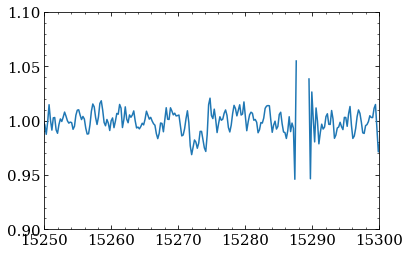

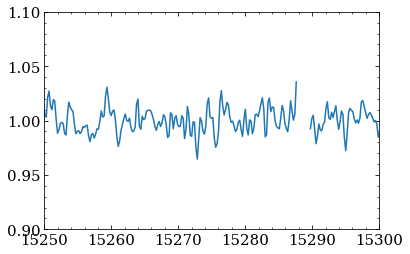

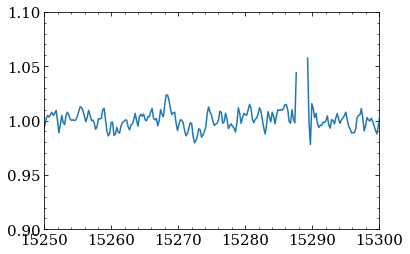

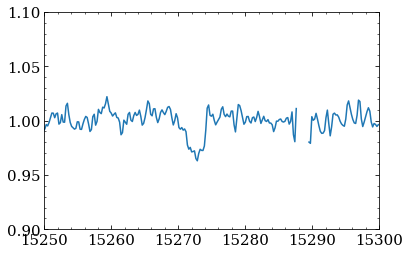

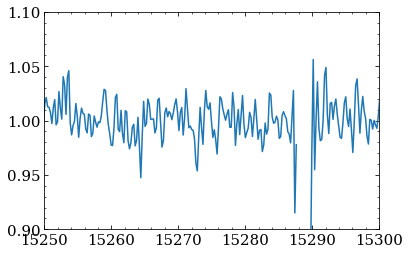

In [250]:
for i in range(5):
    ca = CA_meta[i]
    print(ca['MEDRES_NBIN'])
    residual_nowav = fits.open('CACloudResiduals/' + 'nowav_' + ca['FILE'])
    residual_nowav = fits.open('CACloudResiduals/' + ca['FILE'])
    fig, ax = plt.subplots()
    ax.plot(residual_nowav[3].data, residual_nowav[1].data)
    ax.plot(residual[3].data, residual[1].data)
    
    ax.set_xlim(15250, 15300)
    ax.set_ylim(0.9, 1.1)
#     plt.show()

In [327]:
# res_array_nowav = np.zeros((len(CA_meta), len(wavs)))
# dist_sort = np.argsort(1000/CA_meta['GAIAEDR3_PARALLAX'])
# for i in range(len(CA_meta)):
#     row = CA_meta[dist_sort][i]
#     residual = fits.open('CACloudResiduals/'+'nowav_' +row['FILE'])
#     res_array_nowav[i] = residual[1].data
    
dist_sort = np.argsort(1000/CA_meta['GAIAEDR3_PARALLAX'])

res_array = np.zeros((len(CA_meta), len(wavs)))
for i in range(len(CA_meta)):
    row = CA_meta[dist_sort][i]
    residual = fits.open('CACloudResiduals/' + row['FILE'])
    if row['MEDRES_NBIN'] > 5:
        res_array[i] = residual[1].data
    else:
        res_array[i] = residual[2].data


clean = np.where(np.all(np.isnan(res_array), axis = 1) == False)[0]
res_array_clean = res_array[clean]

In [328]:
# 1000/CA_meta['GAIAEDR3_PARALLAX'][dist_sort]

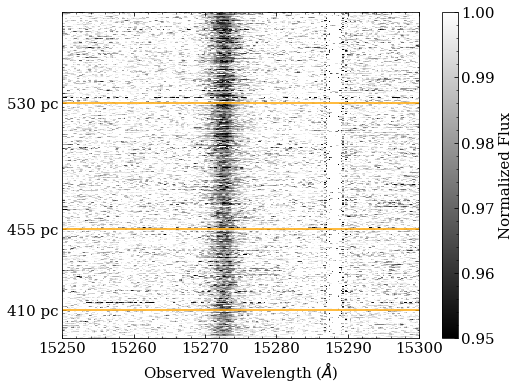

In [342]:
fig, ax = plt.subplots(figsize = (8,6))
norm = colors.Normalize(0.95, 1.0)
extent = (np.min(wavs), np.max(wavs), 0, len(res_array_clean))
xmin, xmax = (15250, 15300)
# xmin, xmax = (np.min(wavs), np.max(wavs))
aspect = 0.5 * (xmax - xmin) / (len(res_array_clean))
im = ax.pcolormesh(wavs, np.arange(len(res_array_clean)),  res_array_clean, shading = 'auto', cmap = 'binary_r', norm = norm)
ax.set_xlim(xmin, xmax)

cloud_min = np.where(1000/CA_meta['GAIAEDR3_PARALLAX'][dist_sort][clean] > 410)[0][0]
cloud_bubble = np.where(1000/CA_meta['GAIAEDR3_PARALLAX'][dist_sort][clean] > 455)[0][0]
cloud_max = np.where(1000/CA_meta['GAIAEDR3_PARALLAX'][dist_sort][clean] > 530)[0][0]

for dist in [cloud_min, cloud_bubble, cloud_max]:
    ax.plot([xmin, xmax], [dist, dist], color = 'orange')
    
ax.set_yticks([cloud_min, cloud_bubble, cloud_max])
ax.set_yticklabels(['410 pc', '455 pc', '530 pc'])


dib = 15272.4
# ax.plot([dib,dib], [*ax.get_ylim()])
# ax.plot([dib,dib], [ax.get_ylim()[0], ax.get_ylim()[0] + 40], color = 'red')
# ax.plot([dib,dib], [ax.get_ylim()[1], ax.get_ylim()[1] - 40], color = 'red')

fig.colorbar(im, label = 'Normalized Flux')
ax.set_xlabel('Observed Wavelength ($\AA$)')
plt.show()

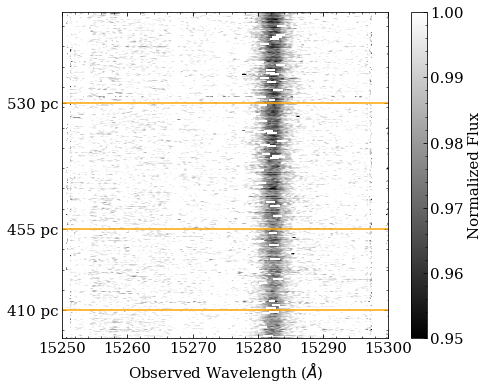

In [341]:
fig, ax = plt.subplots(figsize = (8,6))
norm = colors.Normalize(0.95, 1.0)
extent = (np.min(wavs), np.max(wavs), 0, len(res_array_clean))
xmin, xmax = (15250, 15300)
# xmin, xmax = (np.min(wavs), np.max(wavs))
aspect = (xmax - xmin) / (len(res_array_clean))
im = ax.imshow(np.flip(res_array_clean, axis = 0), extent = extent, aspect = aspect, cmap = 'binary_r', norm = norm)
ax.set_xlim(xmin, xmax)

cloud_min = np.where(1000/CA_meta['GAIAEDR3_PARALLAX'][dist_sort][clean] > 410)[0][0]
cloud_bubble = np.where(1000/CA_meta['GAIAEDR3_PARALLAX'][dist_sort][clean] > 455)[0][0]
cloud_max = np.where(1000/CA_meta['GAIAEDR3_PARALLAX'][dist_sort][clean] > 530)[0][0]

for dist in [cloud_min, cloud_bubble, cloud_max]:
    ax.plot([xmin, xmax], [dist, dist], color = 'orange')
    
ax.set_yticks([cloud_min, cloud_bubble, cloud_max])
ax.set_yticklabels(['410 pc', '455 pc', '530 pc'])


dib = 15272.4
# ax.plot([dib,dib], [*ax.get_ylim()])
# ax.plot([dib,dib], [ax.get_ylim()[0], ax.get_ylim()[0] + 40], color = 'red')
# ax.plot([dib,dib], [ax.get_ylim()[1], ax.get_ylim()[1] - 40], color = 'red')

fig.colorbar(im, label = 'Normalized Flux')
ax.set_xlabel('Observed Wavelength ($\AA$)')
plt.show()

In [314]:
# res_array = np.zeros((len(CA_meta), len(wavs)))
# for i in range(len(CA_meta)):
#     row = CA_meta[dist_sort][i]
#     residual = fits.open('CACloudResiduals/' + row['FILE'])
#     if row['MEDRES_NBIN'] > 5:
#         res_array[i] = residual[2].data
#     else:
#         res_array[i] = residual[2].data


# clean = np.where(np.all(np.isnan(res_array), axis = 1) == False)[0]
# res_array_clean = res_array[clean]

/var/folders/pz/sgyllgv13qnfqwl9zwk1zd380000gn/T/ipykernel_37698/3346033138.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(wavs, np.arange(len(res_array_clean)),  res_array_clean, cmap = 'binary_r', norm = norm)


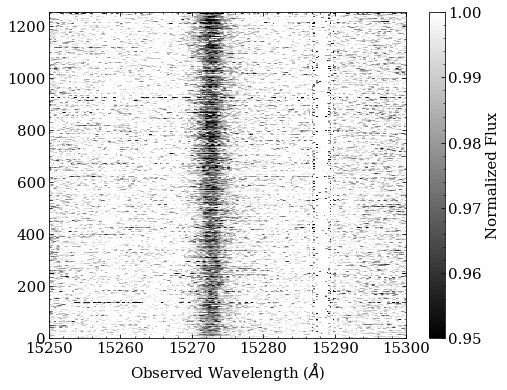

In [315]:
# fig, ax = plt.subplots(figsize = (8,6))
# norm = colors.Normalize(0.95, 1.0)
# extent = (np.min(wavs), np.max(wavs), 0, len(res_array_clean))
# xmin, xmax = (15250, 15300)
# # xmin, xmax = (np.min(wavs), np.max(wavs))
# aspect = 0.5 * (xmax - xmin) / (len(CA_meta))
# im = ax.pcolormesh(wavs, np.arange(len(res_array_clean)),  res_array_clean, cmap = 'binary_r', norm = norm)
# ax.set_xlim(xmin, xmax)
# dib = 15272.4
# # ax.plot([dib,dib], [*ax.get_ylim()])
# fig.colorbar(im, label = 'Normalized Flux')
# ax.set_xlabel('Observed Wavelength ($\AA$)')
# plt.show()

In [325]:

    
# dist_sort = np.argsort(1000/CA_meta['GAIAEDR3_PARALLAX'])

# res_array_nowav = np.zeros((len(CA_meta), len(wavs)))
# dist_sort = np.argsort(1000/CA_meta['GAIAEDR3_PARALLAX'])
# for i in range(len(CA_meta)):
#     row = CA_meta[dist_sort][i]
#     residual = fits.open('CACloudResiduals/'+'nowav_' +row['FILE'])
#     res_array_nowav[i] = residual[1].data


# clean = np.where(np.all(np.isnan(res_array_nowav), axis = 1) == False)[0]
# res_array_nowav_clean = res_array_nowav[clean]

/var/folders/pz/sgyllgv13qnfqwl9zwk1zd380000gn/T/ipykernel_37698/533299935.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(wavs, np.arange(len(res_array_nowav_clean)),  res_array_nowav_clean, cmap = 'binary_r', norm = norm)


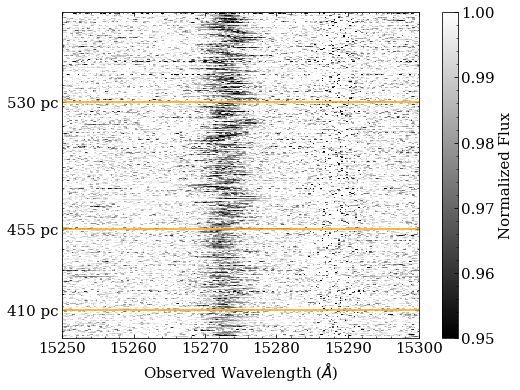

In [326]:
# fig, ax = plt.subplots(figsize = (8,6))
# norm = colors.Normalize(0.95, 1.0)
# extent = (np.min(wavs), np.max(wavs), 0, len(res_array_clean))
# xmin, xmax = (15250, 15300)
# # xmin, xmax = (np.min(wavs), np.max(wavs))
# aspect = 0.5 * (xmax - xmin) / (len(CA_meta))
# im = ax.pcolormesh(wavs, np.arange(len(res_array_nowav_clean)),  res_array_nowav_clean, cmap = 'binary_r', norm = norm)
# ax.set_xlim(xmin, xmax)

# cloud_min = np.where(1000/CA_meta['GAIAEDR3_PARALLAX'][dist_sort][clean] > 410)[0][0]
# cloud_bubble = np.where(1000/CA_meta['GAIAEDR3_PARALLAX'][dist_sort][clean] > 455)[0][0]
# cloud_max = np.where(1000/CA_meta['GAIAEDR3_PARALLAX'][dist_sort][clean] > 530)[0][0]

# for dist in [cloud_min, cloud_bubble, cloud_max]:
#     ax.plot([xmin, xmax], [dist, dist], color = 'orange')
    
# ax.set_yticks([cloud_min, cloud_bubble, cloud_max])
# ax.set_yticklabels(['410 pc', '455 pc', '530 pc'])


# dib = 15272.4
# # ax.plot([dib,dib], [*ax.get_ylim()])
# fig.colorbar(im, label = 'Normalized Flux')
# ax.set_xlabel('Observed Wavelength ($\AA$)')
# plt.show()

In [73]:
l0, b0 = (163., -8.0)
l = np.arange(l0 - 10., l0 + 10., 0.05)
b = np.arange(b0 - 10., b0 + 10., 0.05)
l, b = np.meshgrid(l, b)
coords = SkyCoord(l*u.deg, b*u.deg,
                  distance=455.*u.kpc, frame='galactic')

bayestar = BayestarWebQuery(version='bayestar2019')
reddening = bayestar(coords, mode='random_sample').astype(float)

CA_star_coords = SkyCoord(l = CA_clean['GLON'], b = CA_clean['GLAT'], unit = 'deg', frame = 'galactic')

NameError: name 'extent' is not defined

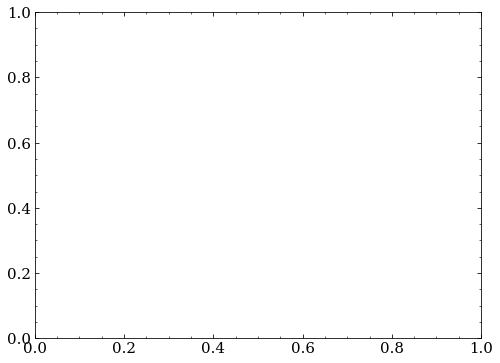

In [74]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.imshow(
    np.sqrt(reddening)[::,::-1],
    vmin=0.,
    vmax=2.,
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal',
    extent = extent
)

ax.scatter(CA_star_coords.l, CA_star_coords.b, s = 2, c= 'r')
ax.set_xlim(168, 158)
ax.set_ylim(-13,-4)

ax.set_xlabel('$l$')# (J2000)')
ax.set_ylabel('$b$')# (J2000)')
plt.show()